# Example Using the `wine` Dataset

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
import featuristic as ft
import numpy as np

np.random.seed(8888)

print(ft.__version__)

1.0.1


### Load the Data

In [2]:
X, y = ft.fetch_wine_dataset()

X.head()

,alcohol,malicacid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0d280_0d315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

### Genetic Feature Synthesis

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

synth = ft.GeneticFeatureSynthesis(
    num_features=5,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    parsimony_coefficient=0.05,
    n_jobs=1,
)
synth.fit(X_train, y_train)

None

Creating new features...:  29%|████▋           | 29/100 [00:05<00:12,  5.74it/s]


### View the Synthesised Features and Their Formulas

In [5]:
generated_features = synth.transform(X_train)

generated_features.head()

,alcohol,malicacid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,0d280_0d315_of_diluted_wines,proline,feature_24,feature_3,feature_0,feature_1,feature_10
0,12.17,1.45,2.53,19.0,104,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355,-0.243548,-19.029967,0.211763,0.249479,-18.931961
1,13.87,1.90,2.80,19.4,107,2.95,2.97,0.37,1.76,4.50,1.25,3.40,915,0.008763,-105.615575,0.016827,0.016909,-89.365658
2,12.51,1.73,1.98,20.5,85,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672,-0.134808,-29.173268,0.117513,0.136657,-28.609145
3,13.88,1.89,2.59,15.0,101,3.25,3.56,0.17,1.70,5.43,0.88,3.56,1095,0.056938,-92.415946,-0.031179,-0.032054,-80.099472
4,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,-0.564359,74.472843,0.512865,0.550195,67.989552


In [6]:
info = synth.get_feature_info()
info

,name,formula,fitness
0,feature_24,sin((sin((-(flavanoids) / cos((square(ash) / a...,-0.808449
1,feature_3,((cos(flavanoids) + magnesium) - sin(abs(cos(p...,-0.821675
2,feature_0,sin((sin(sin(abs(-(flavanoids)))) / (flavanoid...,-0.822068
3,feature_1,sin((sin(flavanoids) / (flavanoids + 0d280_0d3...,-0.821911
4,feature_10,((sin(cos(flavanoids)) + magnesium) - sin(abs(...,-0.819321


### Feature Selection

In [7]:
def objective_function(X, y):
    model = KNeighborsClassifier()
    scores = cross_val_score(model, X, y, cv=3, scoring="f1_weighted")
    return scores.mean() * -1

In [8]:
selector = ft.GeneticFeatureSelector(
    objective_function,
    population_size=200,
    max_generations=100,
    early_termination_iters=25,
    n_jobs=-1,
)

selector.fit(generated_features, y_train)

selected_features = selector.transform(generated_features)

Optimising feature selection...:  24%|██▏      | 24/100 [00:09<00:29,  2.56it/s]


### View the Selected Features

In [9]:
selected_features.head()

,alcohol,malicacid,ash,total_phenols,flavanoids,proanthocyanins,0d280_0d315_of_diluted_wines,feature_24,feature_1
0,12.17,1.45,2.53,1.89,1.75,1.03,2.23,-0.243548,0.249479
1,13.87,1.90,2.80,2.95,2.97,1.76,3.40,0.008763,0.016909
2,12.51,1.73,1.98,2.20,1.92,1.48,3.57,-0.134808,0.136657
3,13.88,1.89,2.59,3.25,3.56,1.70,3.56,0.056938,-0.032054
4,13.40,3.91,2.48,1.80,0.75,1.41,1.56,-0.564359,0.550195


### Compare New Features to Original Features

In [10]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
original_f1 = f1_score(y_test, preds, average="weighted")
original_f1

0.7013084602631234

In [11]:
model = KNeighborsClassifier()
model.fit(selected_features, y_train)
test_features = selector.transform(synth.transform(X_test))
preds = model.predict(test_features)
featuristic_f1 = f1_score(y_test, preds, average="weighted")
featuristic_f1

0.965358758528083

In [12]:
print(f"Original F1: {original_f1}")
print(f"Featuristic F1: {featuristic_f1}")
print(f"Improvement: {round(((featuristic_f1 / original_f1) - 1) * 100, 1)}%")

Original F1: 0.7013084602631234
Featuristic F1: 0.965358758528083
Improvement: 37.7%


### View the History of the Genetic Algorithms

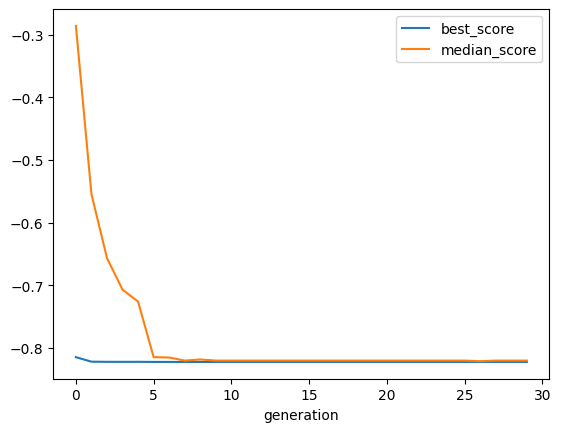

In [13]:
synth.plot_history()

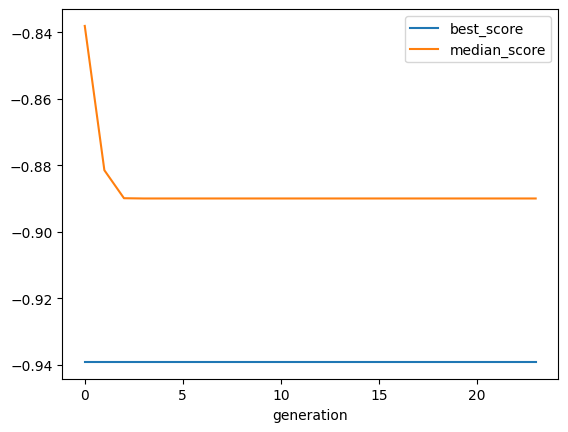

In [14]:
selector.plot_history()